# <font color='red'>Lab 08 - The Indulgence of Air Conditioning </font>

### EARTH 468: Data Analysis & Model Estimation

##### Lab developed by E.A. Hetland

#### Due by the beginning of the lab period for the week of November 17, 2021 (2 weeks).

**For full credit:** 

Be sure to include your name with your notebook either as a markdown cell or in the file name. 

Write any necessary code in code cells below the description of each question. Write any discussion answers in markdown cells below the code cells, not as comments in your code. Be explicit about what you are answering and write in complete sentences. 

If you are asked to include a plot, make sure to label the axes and include a descriptive title.

To turn in this assignment, in the Jupyter toolbar select File/Download as/html or pdf. Make sure that all of your outputs are clear. Upload the downloaded file to the proper assignment submission page on Canvas. Please do not turn in a .ipynb file.

**Objective:** The objective of this lab is to implement a Monte Carlo model state search, and a Bayesian rejection strategy.

**Python Objective:** Implementing a Monte Carlo search scheme and a Monte Carlo rejection scheme in Python.

**Data:** In this lab, we will use data from the 2013 American Housing Survey, US Census (www.census.gov/programs-surveys/ahs/; accessed August 2016), specifically the percentage of households (including both owner occupied and rentals) that have central air conditioning and the median cost per month spent on housing, as a percentage of income. The survey covered 25 major US cities, but in this example we only consider 7 of those cities along the eastern seaboard (see map below).

<img src="Lab_AHS-AC_map.jpeg">

<img src="Lab_AHS-AC_data.jpeg">

The uncertainties in AC % are negligible compared to the monthly cost, so let’s treat
monthly cost as data which depends on AC. This might not make all that much sense, as the dependency
would seem to be the other way around, households with more disposable income are more likely to
have AC. Since the errors are standard error, which depends on the number of households surveys as
well as the sample standard deviation of the responses from those households, the negligible standard
error on AC usage reflects that there is relatively little variation in AC prevalence in each of the cities, while
there is rather large variations in monthly housing costs within each of the cities.

# <font color='orange'>Excercise - 40 pts</font>

Let’s posit the model:


$$c[AC] = c[AC;A,\lambda] = A\, \mathrm{sech}(\frac{AC}{\lambda}) = \frac{A\,} {\cosh(\frac{AC}{\lambda})}$$

Let $c$ = data, $AC$ = data context, and $(A,\lambda)$ = model state.

Note that if $\lambda$ is too small, taking the $\mathrm{sech}$ of a very large number might have numerical issues in Python.
    
Since the c values for AC up to 80 are non-zero, λ probably has to be greater than about 10.

By setting monthly cost as the dependent variable (i.e., data), and AC as independent (i.e., data context), the above model system
is then a predictive model, in which if we knew the average percentages of households with AC in a given city, we could estimate what we’d expect the monthly housing cost, as percent of income, to be.

<img src="Lab_AHS-AC_system.jpeg">

# <font color='red'>Import Libraries:</font>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Read in data:
AHS_df = pd.read_csv('AHS_ACvsMoCost.csv')
AHS_df

,city,lat,lon,monthly cost as % of income,stde,% occupied households with central AC,stde_1
0,New_York_City,40.664274,-73.938500,30,0.987,0.211369,0.034045
1,Boston,42.331960,-71.020173,26,1.432,0.342491,0.036595
2,Northern_New_Jersey,40.724220,-74.172573,28,0.316,0.524095,0.081403
3,Philadelphia,40.009375,-75.133346,25,0.707,0.575164,0.076356
4,Baltimore,39.300213,-76.610516,23,0.725,0.813280,0.032042
5,Richmond,37.531399,-77.476009,22,0.975,0.883692,0.031337
6,Washington,38.904148,-77.017094,23,0.922,0.905582,0.029994


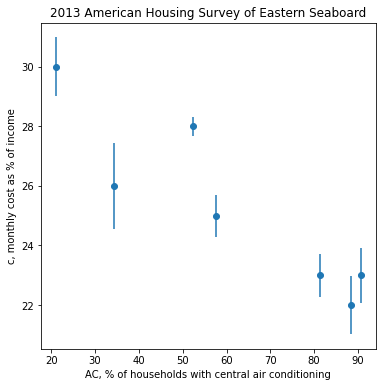

In [6]:
# Plot of data with data uncertainty shown as error bars:

AC_dc = np.array(AHS_df['% occupied households with central AC'])*100 #data context: percent of homes with air conditioning (AC)
cost_data = np.array(AHS_df['monthly cost as % of income']) #data: percent of monthly income used for housing
cost_unc = np.array(AHS_df['stde']) #uncertainty on data: standard error

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.errorbar(AC_dc,cost_data,yerr=cost_unc,linestyle='None',marker='o')
ax.set_xlabel('AC, % of households with central air conditioning')
ax.set_ylabel('c, monthly cost as % of income')
ax.set_title('2013 American Housing Survey of Eastern Seaboard');

## <font color='red'>a) 4 pt</font>
Is the model system linear or non-linear with respect to the model state?

In [7]:
# The model system is non-linear with respect to the model state because the lambda (a model state parameter) is in the denominator. 

def costs(AC, A, lamda): # AC is data context, A and lamda are model state parameters
    return A/np.cosh(AC/lamda) # np.cosh is hyperbolic cosecant


## <font color='red'>b) 4 pt</font>
Should we use L1 or L2 to explore distance for this problem? Why?

In [8]:
# L2 has heightened sensitivity to uncertainty. We will use L1 to explore distance for this problem since it's more robust to outliers and less sensitive to uncertainty.

def L1(data,pred,unc):
    return np.sum(np.abs(data-pred)/unc,axis=1)

## <font color='red'>c) 6 pt</font>
Let’s use a Monte Carlo search to construct the misfit surface. Construct a set of N trial model states, with each trial model state being randomly chosen, uniformly, between the parameter ranges that you determine.

What parameter ranges allow you to find a solution? Hint: You might need to iterate on different ranges. Plotting the misfit surface as a contour plot for each iteration will help you find an appropriate range.

In [9]:
A_range = [29,34]
lamda_range = [90,120]

N = 1*10**4

As = np.random.uniform(A_range[0],A_range[1],N)
lamdas = np.random.uniform(lamda_range[0],lamda_range[1],N)

trials = np.array([As,lamdas]).T
trials

array([[ 30.75725555,  99.19212145],
       [ 33.19640451, 107.26317976],
       [ 32.32062284,  91.66651781],
       ...,
       [ 32.7764271 , 118.59427208],
       [ 32.04998754, 102.23054395],
       [ 32.85737547, 107.28154223]])

In [10]:
costs(AC_dc,trials[0,0],trials[0,1])

array([30.07192364, 29.01069935, 26.91249125, 26.22380136, 22.69276081,
       21.60232493, 21.26310673])

In [11]:
# for loop approach to iterate through N trial states:

predictions = []
for i in range(N):
    preds = costs(AC_dc, trials[i,0], trials[i,1])
    predictions.append(preds)
    
predictions = np.array(predictions) # convert to array
np.shape(predictions)

(10000, 7)

In [12]:
# list comprehension approach:
# np.array([costs(AC_dc,trials[i,0],trials[i,1]) for i in range(N)])

In [13]:
L1_misfits = L1(cost_data, predictions, cost_unc)

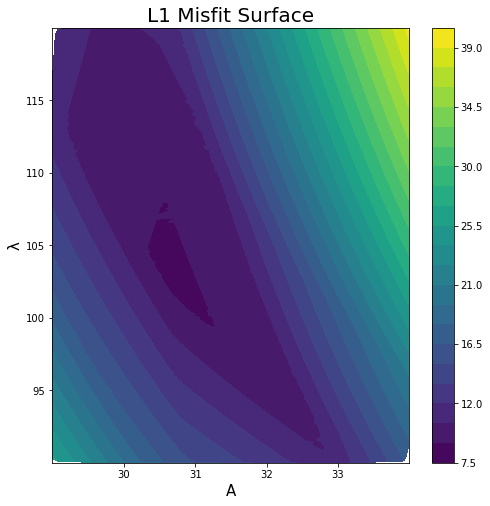

In [14]:
#Contour plot for the misfit surface:

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
contour = ax.tricontourf(trials[:,0],trials[:,1],L1_misfits,levels=20)
ax.set_xlabel('A',size=15)
ax.set_ylabel('λ',size=15)
ax.set_title('L1 Misfit Surface',size=20)

fig.colorbar(contour)

An A range of 29, 34 and a lambda range of 90, 120 allows us to find a solution.

## <font color='red'>d) 8 pt</font>
Find the best solution. Plot the model predictions for the best solution along with the data. 

In [15]:
index_bestsolution = np.where(L1_misfits==min(L1_misfits))[0]
# L1_misfits[index_bestsolution],min(L1_misfits) Checks that index corresponds to lowest misfit, ie best solution
best_model = trials[index_bestsolution][0]
best_predictions = predictions[index_bestsolution]

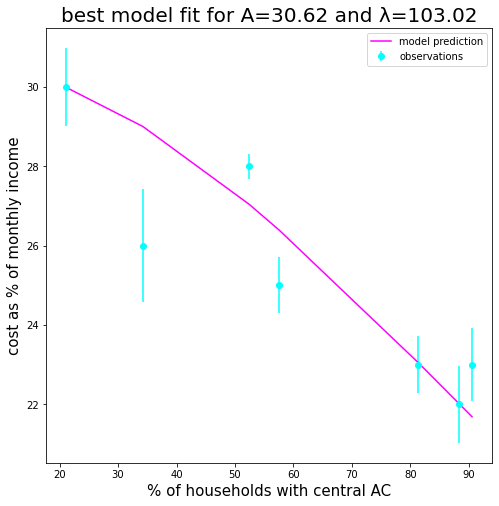

In [16]:
# Plot data and the most likely model predictions:

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.errorbar(AC_dc,cost_data,yerr=cost_unc,linestyle='None',marker='o',label='observations',color='cyan')

ax.plot(AC_dc,best_predictions.T,color='magenta',label='model prediction')

ax.set_xlabel('% of households with central AC',size=15)
ax.set_ylabel('cost as % of monthly income',size=15)

ax.set_title('best model fit for A={} and λ={}'.format(round(best_model[0],2),round(best_model[1],2)),size=20)

ax.legend();

## <font color='red'>e) 6 pt</font>

Let’s now determine the likelihoods of the predictions relative to the most likely predictions:

$$ L_{model} = \frac{e^{-\sqrt{2}L_1}}{L_{\mathrm{MLE}}} = \frac{e^{-\sqrt{2}L_1}}{e^{-\sqrt{2}\min(L_1)}} = e^{-\sqrt{2}(L_1 - \min(L_1))} $$

What is $L_1$ and $L_{\mathrm{MLE}}$ of the best model state you found?

In [17]:
def L1_likelihood(L1_misfit):
    return np.exp(-np.sqrt(2)*(L1_misfit - min(L1_misfit)))

L1_likelihoods = L1_likelihood(L1_misfits)

In [18]:
min(L1_misfits), max(L1_likelihoods)

(8.62540911976658, 1.0)

## <font color='red'>f) 4 pt</font>

Let’s now retain model states in which $ L_{\mathrm{model}} \geq r $, where $r$ is a uniform random number between 0 and 1.

Implement such a rejection scheme in Python to the trial samples. What is your acceptance ratio (i.e., how many trial model states are retained out of how many trials)?

In this step ensure that N is large enough such that there are sufficient number of accepted models to result in a well sampled 2D histogram in part (g). (You will need at least $\approx 100$ retained models.)

In [19]:
def acceptance_test(likelihood,models):
    r = np.random.uniform(0,1,np.shape(models)[0])
    accepted = models[likelihood>=r]
    return accepted

accepted_models = acceptance_test(L1_likelihoods,trials)
np.shape(accepted_models)[0]/N

0.0795

## <font color='red'>g) 8 pt</font>
Plot the predictions of 100 accepted models along with the data. Use the Matplotlib
function *plt.hist2d* to plot a 2D histogram of the accepted samples.

In [20]:
accepted_predictions = np.array([costs(AC_dc,accepted_models[i,0],accepted_models[i,1]) for i in range(100)])

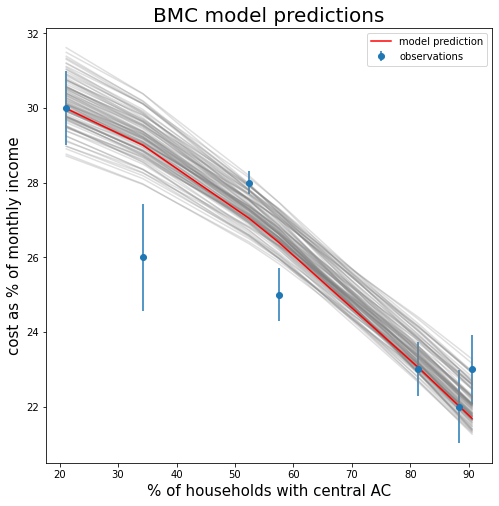

In [21]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
ax.errorbar(AC_dc,cost_data,yerr=cost_unc,linestyle='None',marker='o',label='observations')

ax.plot(AC_dc,accepted_predictions.T,color='gray',alpha=0.25) #100 accepted predictions 
ax.plot(AC_dc,best_predictions.T,color='red',label='model prediction')

ax.set_xlabel('% of households with central AC',size=15)
ax.set_ylabel('cost as % of monthly income',size=15)

ax.set_title('BMC model predictions',size=20)

ax.legend();

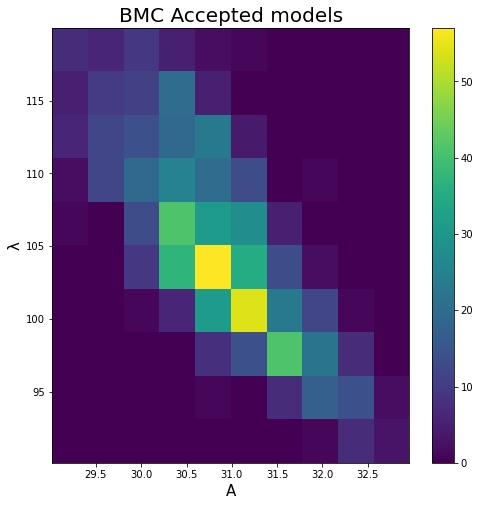

In [22]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111)
hist = ax.hist2d(accepted_models[:,0],accepted_models[:,1])
ax.set_xlabel('A',size=15)
ax.set_ylabel('λ',size=15)
ax.set_title('BMC Accepted models',size=20)
fig.colorbar(hist[3])